# diffusion phantom segmentation

* reference image with manual segmentation
* calculating transformation from target image to the reference
* applying the transform on the manual segmentation

In [1]:
# load modules
%matplotlib inline
import matplotlib.pyplot as plt
import math
import numpy as np
from skimage import data, color, transform
from skimage.transform import rescale, resize, pyramid_reduce
from skimage import data
from skimage import transform as tf
from skimage.transform import rotate
import nibabel as nib
import scipy.optimize
from numpy import ogrid
from skimage import feature
from scipy import ndimage


In [2]:
# set constants
vmin, vmax = 0, 2000
int_thr_ref = 100
low_threshold_edge = 0.00
high_threshold_edge = 0.01
init_rot = 150


In [3]:
# read images

dn = '/home/zmikhelzon/research/phantom/'
fn_1 = dn + '2018_02_1_avg.nii.gz'
fn_2 = dn + 'base.nii.gz'
fn_seg = dn + 'mask_z4.nii.gz'
img_a_nib = nib.load(fn_1)
img_b_nib = nib.load(fn_2)
img_a = img_a_nib.get_data()
img_b = img_b_nib.get_data()[:,:,-1,0].astype(np.float32)
seg = nib.load(fn_seg).get_data()[:,:,-1]

In [4]:
# calculate factor for image resolution correction
factor = img_b_nib.header.get_zooms()[0] / img_a_nib.header.get_zooms()[0]
print factor

0.8674699


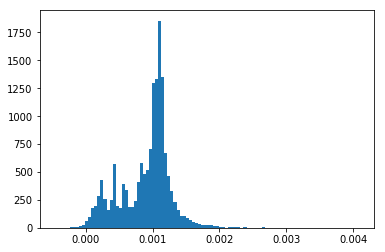

In [5]:
#Threshold differences found and graphed, will later be used to find peak max and min of the images
y_a, bins_a, _ = plt.hist(img_a.flatten(), bins=100)

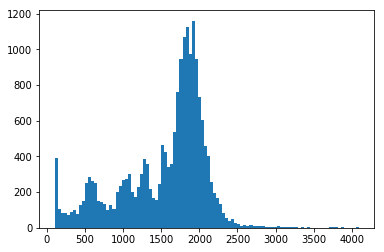

In [6]:
y_b, bins_b, _ = plt.hist(img_b[img_b>int_thr_ref].flatten(), bins=100)

In [7]:
# calculate intensity factor
int_factor = bins_b[np.argmax(y_b)] / bins_a[np.argmax(y_a)]
print int_factor

1749586.2


In [8]:
img_a *= int_factor

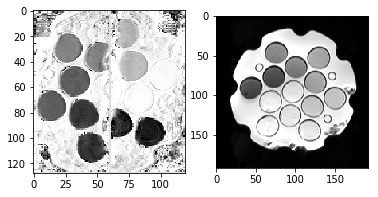

In [9]:
fig, subs = plt.subplots(ncols=2)
subs[0].imshow(img_a.T, cmap='gray', vmin=vmin, vmax=vmax)
subs[1].imshow(img_b.T, cmap='gray', vmin=vmin, vmax=vmax)

In [10]:
# rescale image intensity
img_a /= img_a.max()
img_b /= img_b.max()

/home/kimj77/env/jupyter/local/lib/python2.7/site-packages/skimage/transform/_warps.py:24: UserWarning: The default multichannel argument (None) is deprecated.  Please specify either True or False explicitly.  multichannel will default to False starting with release 0.16.
  warn('The default multichannel argument (None) is deprecated.  Please '
/home/kimj77/env/jupyter/local/lib/python2.7/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


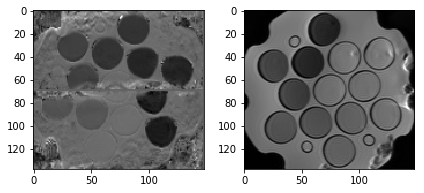

In [11]:
# Resizing image based on voxel factor so that they are the same size

image_a_rescaled = rescale(img_a, 1.0/factor, anti_aliasing = False)
  
fig, ax = plt.subplots(ncols=2)
nx_new, ny_new = image_a_rescaled.shape
nx_ref, ny_ref = img_b.shape[:2]

ax[0].imshow(image_a_rescaled, cmap='gray')
ax[1].imshow(img_b[nx_ref/2-nx_new/2:nx_ref/2+nx_new/2, ny_ref/2-ny_new/2:ny_ref/2+ny_new/2], cmap='gray')

image_b_cropped = img_b[nx_ref/2-nx_new/2:nx_ref/2+nx_new/2, ny_ref/2-ny_new/2:ny_ref/2+ny_new/2]
seg_cropped = seg[nx_ref/2-nx_new/2:nx_ref/2+nx_new/2, ny_ref/2-ny_new/2:ny_ref/2+ny_new/2]
plt.tight_layout()


In [12]:
#redefined new image variables (rescaled)
dat_a = image_a_rescaled.astype(float)
dat_b = image_b_cropped.astype(float)

In [13]:
# rescale image intensity
for dat in [dat_a, dat_b]:
    if dat.min() < 0:
        dat += -dat.min()
    dat /= dat.max()

In [14]:
#Create a circle mask so that interfering contrast in irrelevant parts of the image is reduced (FOR BOTH TARGET AND REFRENCE IMAGES)
def circMask(h, w, center=None, radius=None):
    if center is None:
        center = [int(w/2), int(h/2)]
    if radius is None:
        radius = min(center)
        
    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= radius
    return mask

h, w = dat_a.shape[:2]
mask= circMask(h, w)
masked_img_a = dat_a.copy()
masked_img_a[mask==0] = 0

masked_img_b = dat_b.copy()
masked_img_b[mask==0] = 0

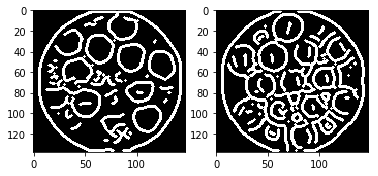

In [15]:
#Building off the peak maxima, edge detection attempts to outline the ROI. Diffierent thresholds in different parts of theimages didn't allow for complete tracing.
#Edges made thicker to hopefullycomplete more of the circles and to make edges more obvious
edgesTest_a = feature.canny(masked_img_a, sigma=3, low_threshold=low_threshold_edge, high_threshold=high_threshold_edge)
thickerEdges_a = ndimage.binary_dilation(edgesTest_a, border_value=0, iterations=1)

edgesTest_b = feature.canny(masked_img_b, sigma=3, low_threshold=low_threshold_edge, high_threshold=high_threshold_edge)
thickerEdges_b = ndimage.binary_dilation(edgesTest_b, border_value=0, iterations=1)

fig, ax = plt.subplots(ncols=2)
ax[0].imshow(thickerEdges_a, cmap=plt.cm.gray)
ax[1].imshow(thickerEdges_b, cmap=plt.cm.gray)

In [16]:
# functions for optimization
def transform(tgt, dx, dy, rot):
    tgt_img, tgt_edge = tgt
    tform = tf.SimilarityTransform(scale=1, rotation=0, translation=(dx, dy))
    rotated = tf.warp(tgt_img, tform)
    rotated = rotate(rotated, angle=rot)
    
    if tgt_edge is not None:
        rotated_edge = tf.warp(tgt_edge, tform)
        rotated_edge = rotate(rotated_edge, angle=rot)
        return rotated, rotated_edge
    return rotated, None

def dist1(tgt, dst=dat_b, mask=mask, edge_b=thickerEdges_b):
    tgt_img, tgt_edge = tgt
    if tgt_edge is not None:
        mask = np.logical_and(mask, np.logical_not(edge_b), np.logical_not(tgt_edge))
    else:
        mask = np.logical_and(mask, np.logical_not(edge_b))
    return((tgt_img[mask]-dst[mask])**2).sum()

def f(param, tgt=(dat_a, thickerEdges_a)):
    dx, dy, rot = param
    return dist1(transform(tgt, dx, dy, rot))

In [17]:
#Conducs optimization for most accurate transformation
init_rot = 140
rslt = scipy.optimize.minimize(f, x0=(0, 0, init_rot), tol=1.0e-18)
print rslt

      fun: 123.6404647838533
 hess_inv: array([[ 0.11302652,  0.0882516 , -0.10059709],
       [ 0.0882516 ,  0.08146402, -0.07735178],
       [-0.10059709, -0.07735178,  0.09629728]])
      jac: array([9.53674316e-07, 2.86102295e-06, 0.00000000e+00])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 111
      nit: 13
     njev: 22
   status: 2
  success: False
        x: array([  0.4338185,   0.5968674, 139.807703 ])


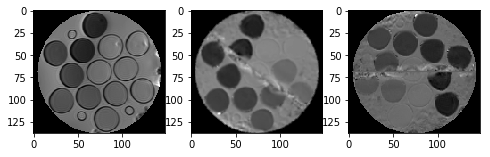

In [18]:
#Application of the determined rotation transformation

rotated, rotated_edge = transform((masked_img_a, thickerEdges_a), *rslt.x)
fig, ax = plt.subplots(ncols=3, figsize=(8,4))
ax[0].imshow(masked_img_b, cmap=plt.cm.gray)
ax[1].imshow(rotated, cmap=plt.cm.gray)
ax[2].imshow(masked_img_a, cmap=plt.cm.gray)

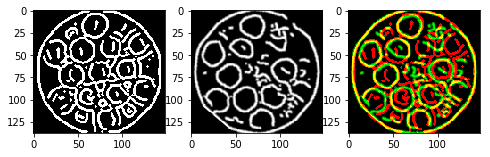

In [19]:
#rotated_edge = transform(thickerEdges_a, *rslt.x)
overlay = np.zeros(thickerEdges_b.shape + (3,), dtype=np.float32)
overlay[:,:,0] = thickerEdges_b
overlay[:,:,1] = rotated_edge

fig, ax = plt.subplots(ncols=3, figsize=(8,4))
ax[0].imshow(thickerEdges_b, cmap=plt.cm.gray)
ax[1].imshow(rotated_edge, cmap=plt.cm.gray)
ax[2].imshow(overlay)

In [20]:
# target -> reference

overlay_seg_b = np.zeros(masked_img_b.shape + (3,), dtype=np.float32)
overlay_seg_b[:,:,0] = masked_img_b.copy()
overlay_seg_b[:,:,1] = masked_img_b.copy()
overlay_seg_b[:,:,2] = masked_img_b.copy()
overlay_seg_b[seg_cropped>0,0] = 1

overlay_seg = np.zeros(masked_img_b.shape + (3,), dtype=np.float32)
overlay_seg[:,:,0] = rotated.copy()
overlay_seg[:,:,1] = rotated.copy()
overlay_seg[:,:,2] = rotated.copy()
overlay_seg[seg_cropped>0,0] = 1


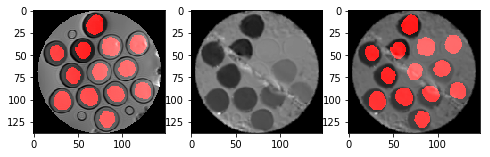

In [21]:
fig, ax = plt.subplots(ncols=3, figsize=(8,4))

ax[0].imshow(overlay_seg_b, cmap=plt.cm.gray)
ax[1].imshow(rotated, cmap=plt.cm.gray)
ax[2].imshow(overlay_seg)

In [22]:
# reference -> target
dx, dy, rot = rslt.x
rotated_b, rotated_seg = transform((masked_img_b, seg_cropped), -dx, -dy, -rot)

overlay_seg = np.zeros(masked_img_b.shape + (3,), dtype=np.float32)
overlay_seg[:,:,0] = masked_img_a.copy()
overlay_seg[:,:,1] = masked_img_a.copy()
overlay_seg[:,:,2] = masked_img_a.copy()
overlay_seg[rotated_seg>0.00002,0] = 1

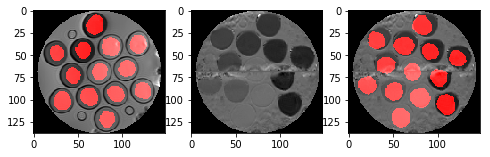

In [23]:
fig, ax = plt.subplots(ncols=3, figsize=(8,4))

ax[0].imshow(overlay_seg_b)
ax[1].imshow(masked_img_a, cmap=plt.cm.gray)
ax[2].imshow(overlay_seg)